### import

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

### get data

In [6]:
# import dataset (comes with colab!)
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

# shape of the data matrix
print(data.shape)

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000, 785)
(20000,)
(20000, 784)


In [7]:
def show_digit_pic(index, data, labels):
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(index))):
        plt.subplot(1, 5, i + 1)
        img = np.reshape(data[index[i], :], (28, 28))
        plt.imshow(img, cmap="gray")
        plt.title("The number %i" % labels[index[i]])
    plt.show()


def digit_in_fnn_vision(index, data, labels):
    n = 0
    fig, axs = plt.subplots(1, 5)
    fig.set_size_inches(12, 3)
    for ax in axs.flatten():
        # create the image
        if n == min(5, len(index)):
            break
        ax.plot(data[index[n], :], "ko")
        ax.set_title("The number %i" % labels[index[n]])
        n += 1
    plt.show()

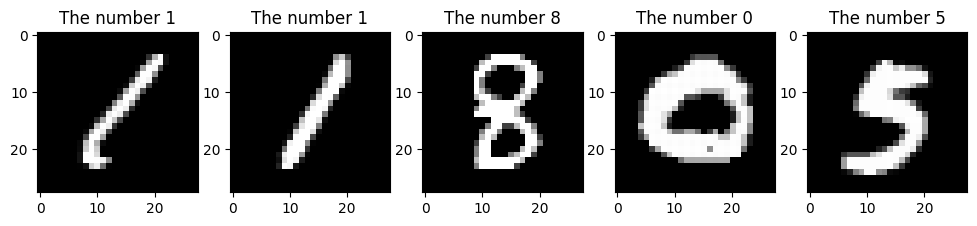

In [8]:
# get 5 random indices and show the corresponding images
indices = np.random.choice(np.arange(data.shape[0]), 5)
show_digit_pic(indices, data, labels)

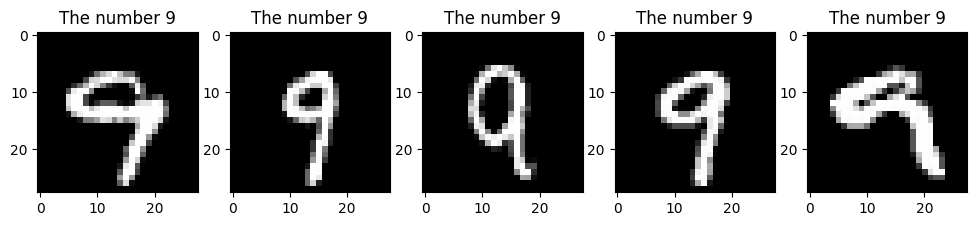

In [9]:
n=9
indices = np.where(labels==n)[0][:5]
show_digit_pic(indices, data, labels)

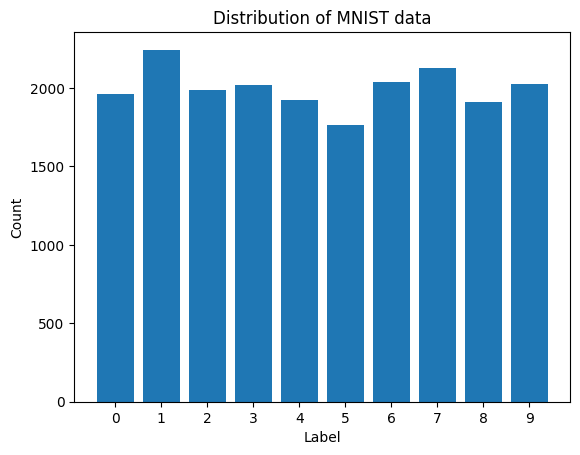

In [10]:
labels_series = pd.Series(labels)
counts = labels_series.value_counts()
plt.bar(counts.index, counts.values)
plt.title('Distribution of MNIST data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(0, 10)) 
plt.show()

### normalize and organize data

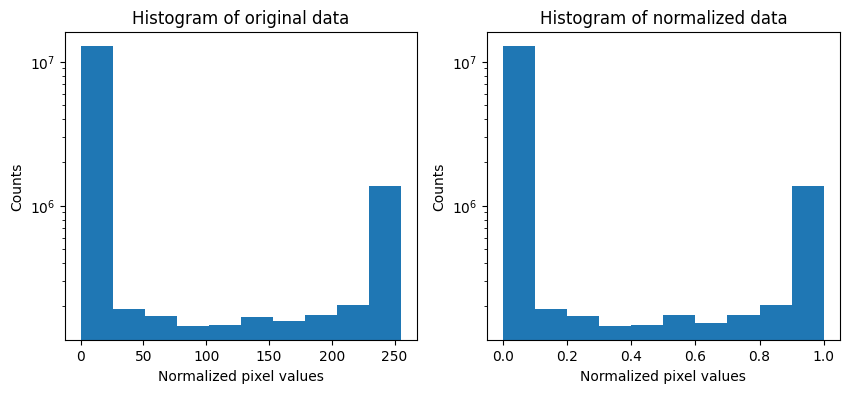

In [11]:
# normalize data
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten())
ax[0].set_xlabel("Normalized pixel values")
ax[0].set_ylabel("Counts")
ax[0].set_title("Histogram of original data")
ax[1].hist(dataNorm.flatten())
ax[1].set_xlabel("Normalized pixel values")
ax[1].set_ylabel("Counts")
ax[1].set_title("Histogram of normalized data")
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.show()

In [12]:
# convert to tensor
dataTensor = torch.tensor(dataNorm, dtype=torch.float)
labelsTensor = torch.tensor(labels, dtype=torch.long)

# split into training and test set
train_data, test_data, train_labels, test_labels = train_test_split(
    dataTensor, labelsTensor, test_size=0.2, random_state=42
)

# convert to torch dataset and to dataloader
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

print("Number of training samples: %i" % len(train_dataset))
print("Number of test samples: %i" % len(test_dataset))
print("Number of batches: %i" % len(train_loader))
print("Shape of one batch: %s" % str(next(iter(train_loader))[0].shape))

Number of training samples: 16000
Number of test samples: 4000
Number of batches: 500
Shape of one batch: torch.Size([32, 784])


### ANN model

In [13]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(784, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
        self.dr = 0.4

    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = nn.BatchNorm1d(128)(x)
        
        x = F.dropout(x, p=self.dr, training=self.training)
        
        x = self.hidden1(x)
        x = F.relu(x)
        x = nn.BatchNorm1d(64)(x)
        
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.hidden2(x)
        x = F.relu(x)
        x = nn.BatchNorm1d(32)(x)
        
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        return x

In [14]:
def create_model():

    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    return model, optimizer, criterion

In [15]:
# test
model, optimizer, criterion = create_model()
data = torch.randn(32, 784)
output = model(data)
print(model)
print(output)
print(output.shape)


ANN(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
tensor([[-2.8928, -1.9824, -2.6362, -2.7963, -1.8730, -2.3216, -2.8694, -3.1531,
         -2.2551, -1.5228],
        [-1.9043, -2.6683, -2.3411, -2.2937, -2.1191, -2.4788, -1.7935, -1.9024,
         -3.3075, -3.5615],
        [-4.5076, -4.0781, -2.1659, -2.4801, -0.7332, -3.1054, -1.9867, -3.5633,
         -3.8844, -2.7735],
        [-2.5702, -2.1528, -2.0257, -2.8369, -1.4313, -2.1757, -3.0127, -3.7850,
         -1.8634, -3.2896],
        [-2.5597, -2.8007, -2.6477, -1.9255, -2.8859, -2.4348, -2.8027, -2.9113,
         -2.6957, -1.1415],
        [-3.4112, -1.8931, -1.7087, -4.3729, -3.0844, -2.0385, -2.4758, -1.9829,
         -2.0747, -2.3093],
        [-1.9373, -3.4027, -2.4979, -2.0531, -1.0983, -3.7856, -2.2720, -3.6098,
  

### train model function

In [16]:
def train_model(train_loader, test_loader):
    model, optimizer, criterion = create_model()
    losses = np.zeros(epochs)
    trainAcc = np.zeros(epochs)
    testAcc = np.zeros(epochs)

    epochs = 100
    for i in range(epochs):
        model.train()
        batchAcc = []
        bactchLoss = []
        # train in batches
        for images, labels in train_loader:
            # forward pass
            outputs = model(images)

            # compute loss
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # store accuracy and loss
            batchAcc.append(
                100 * torch.mean((labels == torch.argmax(outputs, dim=1)).float())
            )
            bactchLoss.append(loss.item())

        # store mean accuracy and loss for the epoch
        losses[i] = np.mean(bactchLoss)
        trainAcc[i] = np.mean(batchAcc)

        # test model
        model.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            outputs = model(x)
            testAcc[i] = 100 * torch.mean((y == torch.argmax(outputs, dim=1)).float())
        sys.stdout.write("\r" + f"Epooch {i+1}/{epochs} loss: {losses[i]:.2f} trainAcc: {trainAcc[i]:.2f}")

    return model, losses, trainAcc, testAcc

### test the model

In [17]:
model, losses, trainAcc, testAcc = train_model(train_loader, test_loader)

# approx time: 5 min

Epooch 100/100 loss: 0.16 trainAcc: 95.51

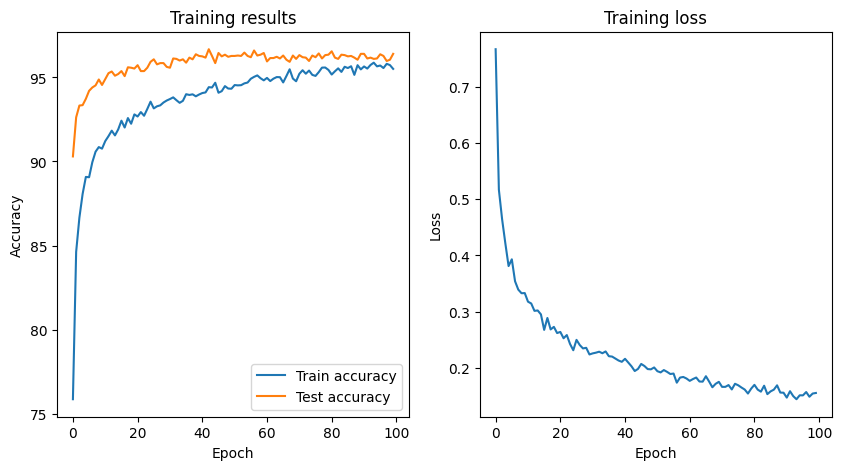

In [18]:
# plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(trainAcc, label="Train accuracy")
plt.plot(testAcc, label="Test accuracy")
plt.legend()
plt.title("Training results")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

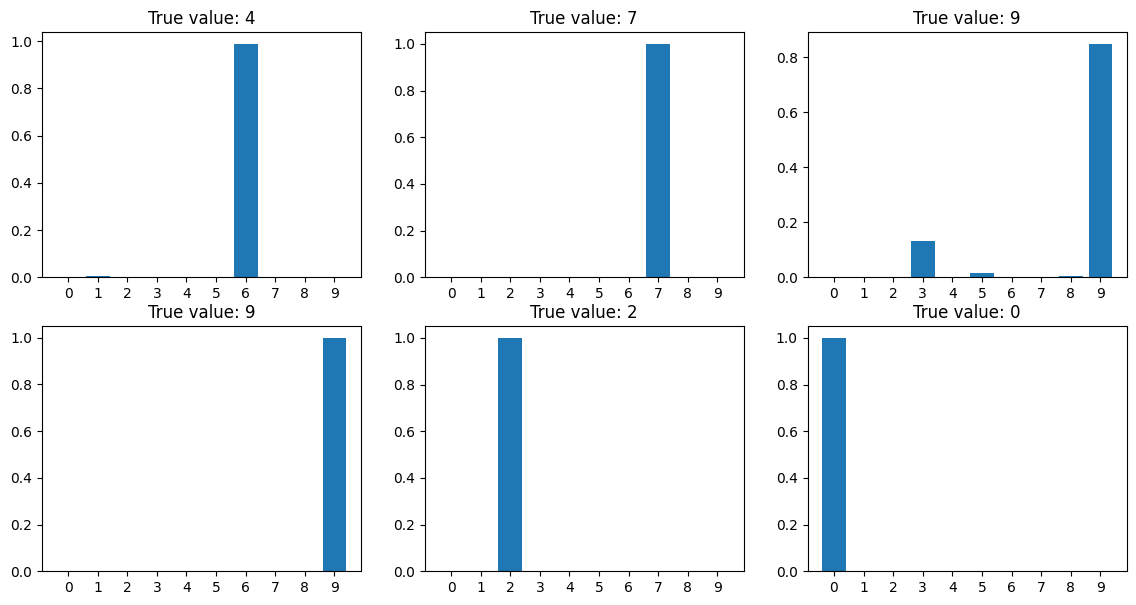

In [19]:
# plot some sample
random_indexs = np.random.randint(0, len(test_dataset), 6)
x, y = test_dataset[random_indexs]
prediction = model(x).detach()

plt.figure(figsize=(14, 7))
for i, pred in enumerate(prediction):
    plt.subplot(2, 3, i + 1)
    plt.bar(range(10), torch.exp(pred))
    plt.xticks(np.arange(10))
    plt.title(f"True value: {y[i]}")
plt.show()

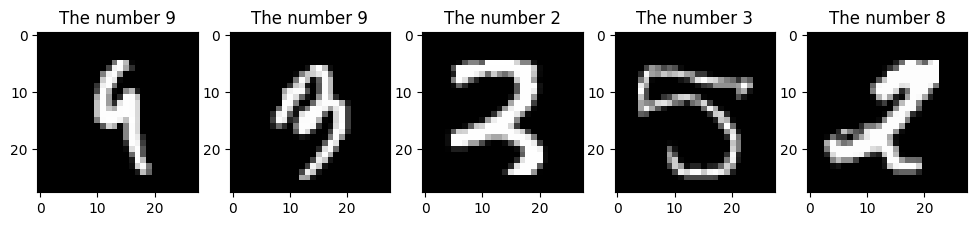

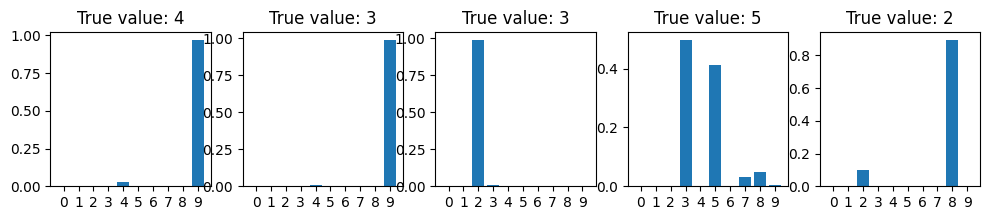

In [24]:
# plot the error values
x, y = next(iter(test_loader))
yhat = model(x).detach()
prediction = torch.argmax(torch.exp(yhat), dim=1)
missed_index = np.array(np.where(prediction != y))[0]
missed_index = np.random.choice(missed_index, 5)
show_digit_pic(missed_index, x, prediction)

plt.figure(figsize=(12, 2))
for i, pred in enumerate(missed_index):
    plt.subplot(1, 5, i + 1)
    plt.bar(range(10), torch.exp(yhat[pred]))
    plt.xticks(np.arange(10))
    plt.title(f"True value: {y[pred]}")
plt.show()


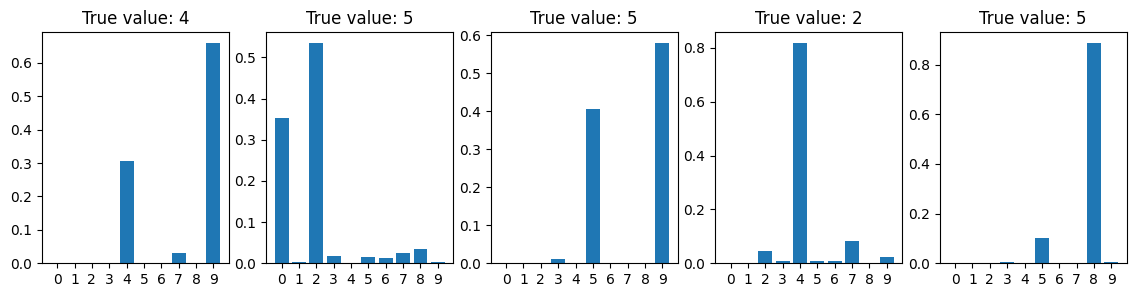

In [21]:
plt.figure(figsize=(14, 3))
for i, pred in enumerate(missed_index):
    plt.subplot(1, 5, i + 1)
    plt.bar(range(10), torch.exp(yhat[pred]))
    plt.xticks(np.arange(10))
    plt.title(f"True value: {y[pred]}")
plt.show()